# 1. XG Boost

In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
import xgboost as xgb
import lightgbm as lgb
import catboost as cbg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\ezlik\AppData\Roaming\Python\Python310\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [17]:
class XGboost():
    
    def __init__(self, symbol, start, end= datetime.datetime.today()):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):
        
        # extract data from yahoo finance
        data = data = yf.download(self.symbol, self.start, self.end)
        
        # target variable
        target = "Close"
        
        # features
        predictor = ["Open", "High", "Low", "Volume"]
        
        # create features
        X = data[predictor]
        y = data[target]
        
        # split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        
        # create model
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # set parameters
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 4,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
        }
        
        # train model
        self.model = xgb.train(params, dtrain, num_boost_round=100)
        
        # evaluate model
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, self.model.predict(dtest))))
        print("R2: ", r2_score(y_test, self.model.predict(dtest)))
        
        # generate entry and exit signals
        data["predicted"] = self.model.predict(xgb.DMatrix(data[predictor]))
        buysignals = data[data["Close"] < data["predicted"]]
        sellsignals = data[data["Close"] > data["predicted"]]
        
        # position
        data["Position"] = np.where(data["Close"] < data["predicted"], 1, -1)
        
        # buy_and_hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))
        
        # strategy returns
        data["strategy"] = data["Position"].shift(1) * data["buy_and_hold"]
        
        # drop na
        data.dropna(inplace=True)
        
        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals    
    
    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} XGBoost Model Performance")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()

[*********************100%***********************]  1 of 1 completed
RMSE:  2.134703283649604
R2:  0.9811262235976187
Sum of buy_and_hold:
buy_and_hold    0.90316
strategy        2.68209
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold   strategy
Date                               
2020-01-03      0.990278   1.009817
2020-01-06      0.998169   1.017864
2020-01-07      0.993474   1.022674
2020-01-08      1.009456   1.006483
2020-01-09      1.030897   1.027862
...                  ...        ...
2023-06-20      2.463925  14.636147
2023-06-21      2.449942  14.719686
2023-06-22      2.490428  14.480393
2023-06-23      2.486166  14.505216
2023-06-26      2.467388  14.615607

[875 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-01-03
End date,2023-06-26
Total months,41
,Backtest
Annual return,103.6%
Cumulative returns,1080.8%
Annual volatility,34.9%
Sharpe ratio,2.21
Calmar ratio,4.34
Stability,0.86
Max drawdown,-23.8%


##################################################


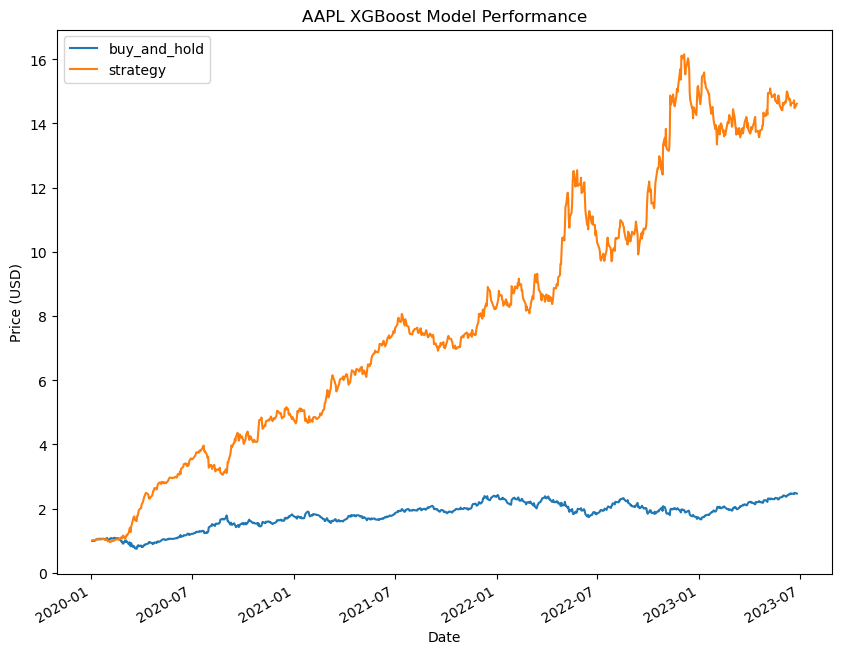

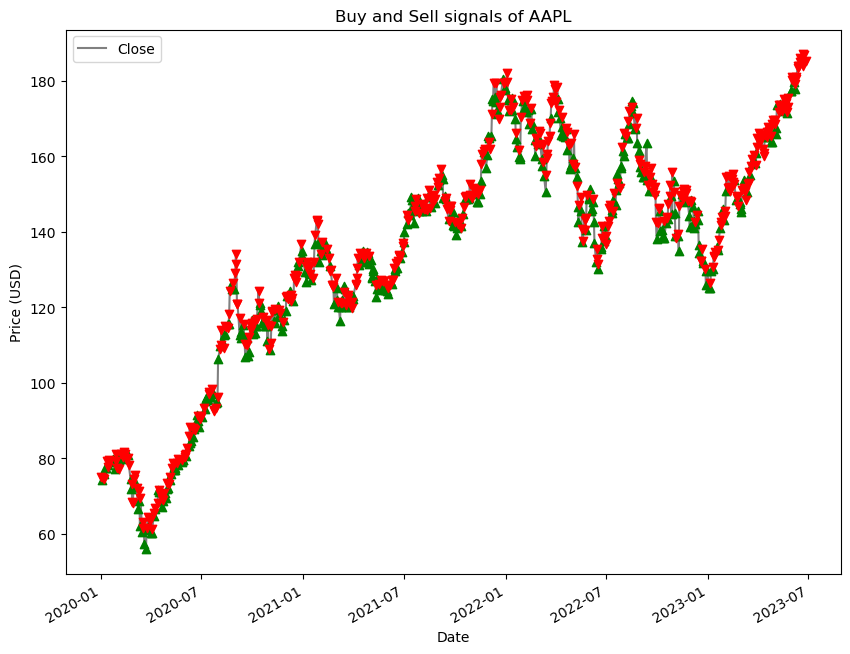

In [18]:
aapl = XGboost("AAPL", "2020-01-01")
aapl.performance_summary()

# 2. LightGBM

In [36]:
class LightGBM():
    
    def __init__(self, symbol, start, end= datetime.datetime.today()):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):
        
        # extract data from yahoo finance
        data = yf.download(self.symbol, self.start, self.end)
        
        # target variable
        target = "Close"
        
        # features
        predictor = ["Open", "High", "Low", "Volume"]
        
        # create features
        X = data[predictor]
        y = data[target]
        
        # split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
              
        # params
        params = {
            'objective': 'regression',
            'metric': 'binary_logloss',
            'max_depth': 4,
            'learning_rate': 0.1,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
        }
                
        # create model
        self.model = lgb.LGBMRegressor(**params)
        self.model.fit(X_train, y_train)
        
        # evaluate model
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, self.model.predict(X_test))))
        print("R2: ", r2_score(y_test, self.model.predict(X_test)))
        
        # generate entry and exit signals
        data["predicted"] = self.model.predict(data[predictor])
        buysignals = data[data["Close"] < data["predicted"]]
        sellsignals = data[data["Close"] > data["predicted"]]
        
        # position
        data["Position"] = np.where(data["Close"] < data["predicted"], 1, -1)
        
        # buy_and_hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))
        
        # strategy returns
        data["strategy"] = data["Position"].shift(1) * data["buy_and_hold"]
        
        # drop na
        data.dropna(inplace=True)
        
        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals    
    
    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} LightGBM Performance")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()
        

[*********************100%***********************]  1 of 1 completed
RMSE:  1.1642244730126694
R2:  0.989031970209908
Sum of buy_and_hold:
buy_and_hold   -0.660874
strategy        2.414762
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold   strategy
Date                               
2020-01-03      0.985889   1.014313
2020-01-06      0.973875   1.026826
2020-01-07      0.967963   1.020593
2020-01-08      0.977498   1.030646
2020-01-09      0.983982   1.023855
...                  ...        ...
2023-06-20      0.531083  11.272211
2023-06-21      0.532990  11.231881
2023-06-22      0.514302  10.838062
2023-06-23      0.507246  10.988816
2023-06-26      0.516400  11.187110

[875 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-01-03
End date,2023-06-26
Total months,41
,Backtest
Annual return,76.5%
Cumulative returns,619.3%
Annual volatility,51.0%
Sharpe ratio,1.36
Calmar ratio,1.59
Stability,0.54
Max drawdown,-48.3%


##################################################


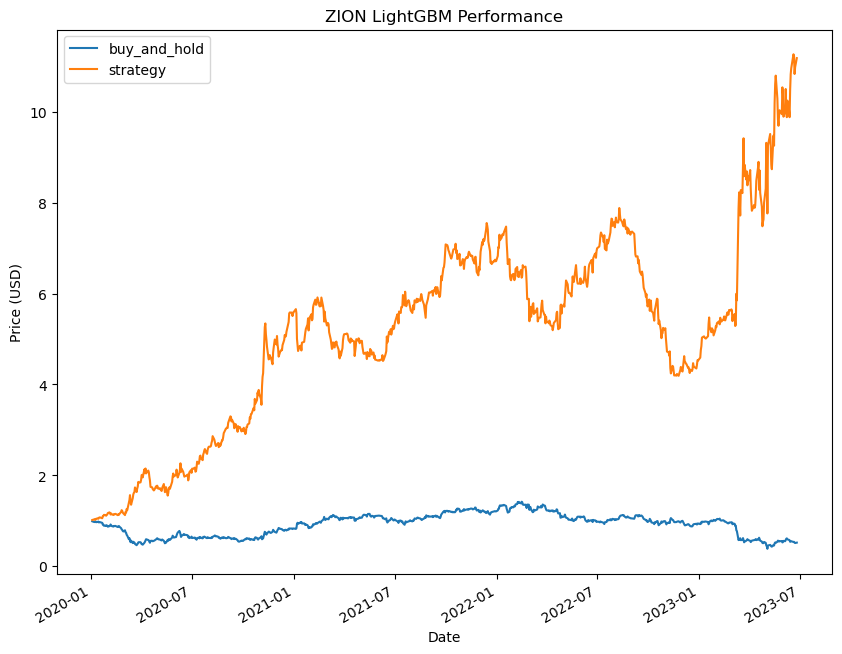

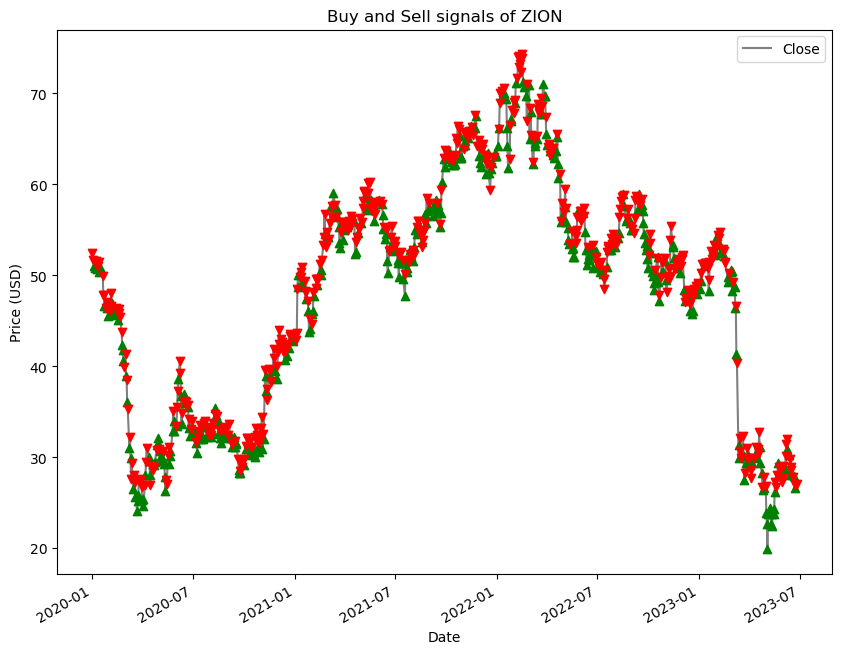

In [39]:
aapl = LightGBM("ZION", "2020-01-01")
aapl.performance_summary()

# 3. CatBoost

In [5]:
class CatBoostModel():
    
    def __init__(self, symbol, start, end= datetime.datetime.today()):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):
        
        # extract data from yahoo finance
        data = yf.download(self.symbol, self.start, self.end)
        
        # target variable
        target = "Close"
        
        # features
        predictor = ["Open", "High", "Low", "Volume"]
        
        # create features
        X = data[predictor]
        y = data[target]
        
        # split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
              
        # params
        params = {
            'objective': 'regression',
            'max_depth': 4,
            'learning_rate': 0.1,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
        }
                
        # create model
        self.model = cbg.CatBoostRegressor(**params)
        self.model.fit(X_train, y_train)
        
        # evaluate model
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, self.model.predict(X_test))))
        print("R2: ", r2_score(y_test, self.model.predict(X_test)))
        
        # generate entry and exit signals
        data["predicted"] = self.model.predict(data[predictor])
        buysignals = data[data["Close"] < data["predicted"]]
        sellsignals = data[data["Close"] > data["predicted"]]
        
        # position
        data["Position"] = np.where(data["Close"] < data["predicted"], 1, -1)
        
        # buy_and_hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))
        
        # strategy returns
        data["strategy"] = data["Position"].shift(1) * data["buy_and_hold"]
        
        # drop na
        data.dropna(inplace=True)
        
        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals
    
    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} LightGBM Performance")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()

In [6]:
zion = CatBoostModel("ZION", "2020-01-01")
zion.performance_summary()

[*********************100%***********************]  1 of 1 completed


TypeError: CatBoostRegressor.__init__() got an unexpected keyword argument 'colsample_bytree'